# ssp.train.py

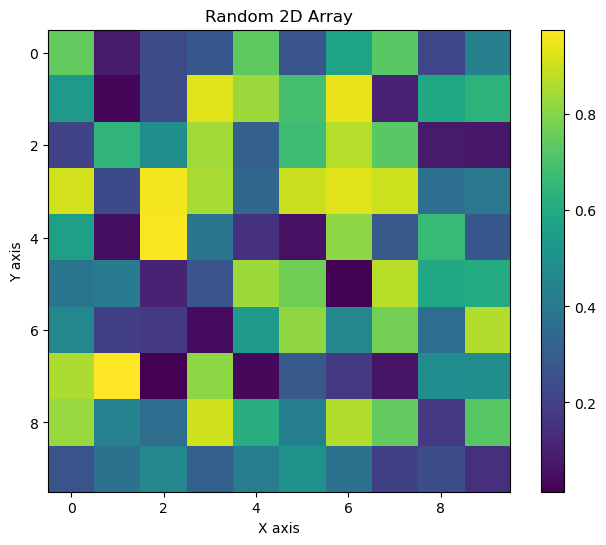

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
# LIF + FC 네트워크 정의 (FC 레이어를 먼저 적용한 후 LIF 레이어)
class LIF_FC_Network(nn.Module):
    def __init__(self, v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on, input_size, hidden_size, output_size):
        super(LIF_FC_Network, self).__init__()
        # Fully Connected 레이어
        self.fc_layer = nn.Linear(input_size, hidden_size, bias=False)
        # FC 레이어 가중치 초기화 (1로 설정)
        nn.init.constant_(self.fc_layer.weight, 1.0)
        # LIF 레이어
        self.lif_layer = LIF_layer(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on)
        # 최종 출력 레이어
        self.fc_out = nn.Linear(hidden_size, output_size, bias=False)
        nn.init.constant_(self.fc_out.weight, 0.5)

    def forward(self, input_current):
        # FC 레이어를 통과시킨 후 LIF 레이어에 전달
        time = input_current.size(0)
        batch = input_current.size(1)
        x = input_current.view(input_current.size(0)*input_current.size(1), -1)
        x = self.fc_layer(x)  # FC 레이어에 맞게 벡터로 펼침
        x = x.view(time, batch, -1)  # 다시 시계열 데이터로 변환
        # print('fc후\n',x.shape)
        # print('fc후\n',x)
        x = self.lif_layer(x)  # LIF 레이어의 입력으로 사용
        # print('lif후\n',x.shape)
        # print('lif후\n',x)
        x = x.view(x.size(0)*x.size(1), -1)
        x = self.fc_out(x)  # 최종 출력
        x = x.view(time, batch, -1)  # 다시 시계열 데이터로 변환
        # print('최종fc후\n', x.shape)
        # print('최종fc후\n', x)
        return x


# 모델 초기화
input_size = 1  # 입력 특징 수
hidden_size = 1  # FC 레이어의 은닉층 크기
output_size = 1  # 출력 크기

time = 10
batch = 1

v_init = 0.0
v_decay = 0.5
v_threshold = 1
v_reset = 0.0
sg_width = 4.0
surrogate = 'sigmoid'
BPTT_on = True # True False

# 모델 정의
model = LIF_FC_Network(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on, input_size, hidden_size, output_size)

# input_current를 0.5로 채운 텐서로 생성
input_current = torch.full((time, batch, input_size), 0.5, requires_grad=False)

# 손실 함수 및 최적화 설정
loss_fn = nn.MSELoss()


optimizer = optim.SGD(model.parameters(), lr=0.01)



In [3]:
print(model)
for i in range(100):
    # 출력 확인
    # print('input\n',input_current.size())
    # print('input\n',input_current)
    output = model(input_current)
    print(output.size())
    tensors = [output[i] for i in range(time)] 
    all_equal = all(torch.equal(tensors[0], t) for t in tensors)
    print(all_equal)
    # if all_equal == False:
    #     print('\n\n\n\nnot equal\n\n\n')
    #     print(output)
    
    target = torch.ones_like(output)

    # 훈련
    optimizer.zero_grad()
    loss = loss_fn(output, target)

    # 각 변수에 이름 추가
    params = {name: param for name, param in model.named_parameters()}
    inputs = {"input_current": input_current}
    # Backward 그래프 그리기
    dot = make_dot(loss, params={**params, **inputs}, show_attrs=True, show_saved =False)

    # 그래프 저장 및 보기
    dot.render("LIF_FC_Network_Backward", format="png", cleanup=True)

    loss.backward()

    # print("\n각 파라미터의 gradient 값:")
    for name, param in model.named_parameters():
        if 'layer' in name:
            if param.grad is not None:
                if param.grad.sum() != 0:
                    print(f"{name}의 gradient: {param.grad}")
                else:
                    print('zero grad')
            else:
                print(f"{name}의 gradient: None")

    optimizer.step()
    print("훈련 후 손실값:", loss.item())

LIF_FC_Network(
  (fc_layer): Linear(in_features=1, out_features=1, bias=False)
  (lif_layer): LIF_layer()
  (fc_out): Linear(in_features=1, out_features=1, bias=False)
)
torch.Size([10, 1, 1])
True
fc_layer.weight의 gradient: tensor([[-0.8479]])
훈련 후 손실값: 1.0
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.7175]])
훈련 후 손실값: 0.925000011920929
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.7231]])
훈련 후 손실값: 0.9249000549316406
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.7277]])
훈련 후 손실값: 0.9248005747795105
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.7332]])
훈련 후 손실값: 0.9247015118598938
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.6874]])
훈련 후 손실값: 0.8492056131362915
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.6933]])
훈련 후 손실값: 0.8488126993179321
torch.Size([10, 1, 1])
False
fc_layer.weight의 gradient: tensor([[-0.6991]])
훈련 후 손실값: 0.8484230041503906
torch.

In [ ]:

# print(model)

# for i in range(100):
#     # 출력 확인
#     # print('input\n',input_current.size())
#     # print('input\n',input_current)
#     output = model(input_current)

#     target = torch.ones_like(output)

#     # 훈련
#     optimizer.zero_grad()
#     loss = loss_fn(output, target)

#     # 각 변수에 이름 추가
#     params = {name: param for name, param in model.named_parameters()}
#     inputs = {"input_current": input_current}
#     # Backward 그래프 그리기
#     dot = make_dot(loss, params={**params, **inputs}, show_attrs=True, show_saved =False)

#     # 그래프 저장 및 보기
#     dot.render("LIF_FC_Network_Backward", format="png", cleanup=True)

#     loss.backward()

#     # print("\n각 파라미터의 gradient 값:")
#     # for name, param in model.named_parameters():
#     #     if param.grad is not None:
#     #         print(f"{name}의 gradient: {param.grad}")
#     #     else:
#     #         print(f"{name}의 gradient: None")

#     optimizer.step()
#     if i >90:
#         print("훈련 후 손실값:", loss.item())
#     print("훈련 후 손실값:", loss.item())